In [23]:
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.utils as utils
from torch.autograd import Variable

import math

from blackhc.mdp import dsl
from blackhc import mdp
import time

from blackhc.mdp import lp
import functools
import numpy as np

from tqdm import tqdm
from matplotlib import pyplot as plt
from numpy import random

from operator import itemgetter

from collections import defaultdict


In [24]:
class ReplayMemory:
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = []
        self.position = 0
    def flush_all(self):
        self.buffer = []
        self.position = 0
        return

    def push(self, state, action, reward, next_state,policy):
        if len(self.buffer) < self.capacity:
            self.buffer.append(None)
        self.buffer[self.position] = (state, action, reward, next_state,policy)
        self.position = (self.position + 1) % self.capacity

    def push_batch(self, batch):
        if len(self.buffer) < self.capacity:
            append_len = min(self.capacity - len(self.buffer), len(batch))
            self.buffer.extend([None] * append_len)

        if self.position + len(batch) < self.capacity:
            self.buffer[self.position : self.position + len(batch)] = batch
            self.position += len(batch)
        else:
            self.buffer[self.position : len(self.buffer)] = batch[:len(self.buffer) - self.position]
            self.buffer[:len(batch) - len(self.buffer) + self.position] = batch[len(self.buffer) - self.position:]
            self.position = len(batch) - len(self.buffer) + self.position

    def sample(self, batch_size):
        if batch_size > len(self.buffer):
            batch_size = len(self.buffer)
        batch = random.sample(self.buffer, int(batch_size))
        state, action, reward, next_state,policy = map(np.stack, zip(*batch))
        return state, action, reward, next_state,policy

    def sample_all_batch(self, batch_size):
        idxes = np.random.randint(0, len(self.buffer), batch_size)
        batch = list(itemgetter(*idxes)(self.buffer))
        state, action, reward, next_state,policy = map(np.stack, zip(*batch))
        return state, action, reward, next_state,policy

    def return_all(self):
        return self.buffer

    def __len__(self):
        return len(self.buffer)

In [25]:
class pred_env:
    # initialize
    def __init__(self,horizon_length,k):
        
        self.prev_state =None
        self.curr_state =None
           
        self.state_list=list()
        self.action_list=list()
        self.state_to_action_map=dict()

        
        self.P=defaultdict()
        self.R=defaultdict()
        
        self.horizon_len=horizon_length
        self.terminal_state=None
        self.k=k
    
    def reset(self):
        
        self.state_list=list()
        self.action_list=list()
        self.state_to_action_map=dict()

        
        self.P=defaultdict()
        self.R=defaultdict()
        
    # Parameter Estimation 
    
    def update_param_given_epi(self,D_real):
        
        episodes=D_real.buffer
        

        # following SARSA format
        for epi_id in range(len(episodes)):
    
            t_states, t_actions, t_rewards,t_nstates,t_log_probs = self.cvt_axis(episodes[epi_id])
            i=0 
            while i<len(t_states):
                
                # updating the list of states
                
                if any([torch.equal(x,t_states[i]) for x in self.state_list])!=True:
                    self.state_list.append(t_states[i])
                    self.state_to_action_map.update({t_states[i]:[]})
                
                
                
                # updating the list of actions
            
            

                if any([torch.equal(x,t_actions[i]) for x in self.action_list])!=True:
                    self.action_list.append(t_actions[i])
                    
                if any([torch.equal(x,t_actions[i]) for x in self.state_to_action_map[self.smooth_check(self.state_to_action_map,t_states[i])]])!=True:
                    self.state_to_action_map[self.smooth_check(self.state_to_action_map,t_states[i])].append(t_actions[i])
                
                # # update state,action to next state count map
                
                tru_tup,flag=self.double_smooth_check(self.P,(t_states[i],t_actions[i]))
                if flag!=True:
                    self.P[(t_states[i],t_actions[i])]={t_nstates[i]:1}
                    self.R[(t_states[i],t_actions[i])]={t_nstates[i]:t_rewards[i]}
                    
                else:
                    if any([torch.equal(x,t_nstates[i]) for x in self.P[tru_tup].keys()])!=True:
                        self.P[tru_tup].update({t_nstates[i]:1})
                        self.R[tru_tup].update({t_nstates[i]:t_rewards[i]})
                        
                    else:
                        sec_tup=self.smooth_check(self.P[tru_tup],t_nstates[i])
                        self.P[tru_tup][sec_tup]+=1
                                    
                i+=1  
                
            if self.terminal_state is None and i<self.horizon_len:
                self.terminal_state=t_nstates[i-1]
                self.state_list.append(t_nstates[i-1])
        return 
    
    # Support functions
    def double_smooth_check(self,A,a):
        
        for ele in A.keys():
            if torch.equal(a[0],ele[0]) and torch.equal(a[1],ele[1]):
                return ele,True
        return a,False
    
    def smooth_check(self,A,a):

        for ele in A.keys():
            if torch.eq(a,ele).all():
                return ele
        return a
     
    def cvt_axis(self,traj):
        
        t_states =[]
        t_actions =[]
        t_nstates =[]
        t_rewards=[]
        t_log_probs=[]
        
        for i in range(len(traj[0])):
            t_states.append(traj[0][i])
            t_actions.append(traj[1][i])
            t_rewards.append(traj[2][i])
            t_nstates.append(traj[3][i])
            t_log_probs.append(traj[4][i])

        return (t_states, t_actions, t_rewards,t_nstates,t_log_probs) 
    
    def get_parameters(self):
        print("\nState list")
        print(self.state_list)
        print("\nAction list")
        print(self.action_list)
        print("\nState to action map")
        print(self.state_to_action_map)
        print("\nstate_action to next state")
        for x in self.P:
            print(x)
            print(self.P[x])
        print("\n state_action to reward map")
        for x in self.R:
            print(x)
            print(self.R[x])
        return
    
    def Is_terminal_state(self,s_t):
        if torch.equal(self.terminal_state,s_t):
            return True
        return False
    
    def set_start_state(self):
        if len(self.state_list)>0:
            
            p=[1]*len(self.state_list)
            p=[x/len(self.state_list) for x in p]
            s_t_index=np.random.choice(np.arange(len(self.state_list)),p=p)
            s_t=self.state_list[s_t_index]
            while torch.equal(s_t,self.terminal_state):
                s_t_index=np.random.choice(np.arange(len(self.state_list)),p=p)
                s_t=self.state_list[s_t_index]
            self.curr_state=s_t
        return
    
    def list_check_up(self,A,s_t):
        for x in A:
            if torch.equal(x,s_t):
                return x
        return None
   
    # Fake Data generation functions
    
    def step_v1(self,a_t):
        
        next_state=0
        un_norm_distr=self.P[self.double_smooth_check(self.P,(self.curr_state,a_t))[0]]
        norm_factor=sum(list(un_norm_distr.values()))
        choices=list(un_norm_distr.keys())
        p=[x/norm_factor for x in un_norm_distr.values()]
        
        next_state_id=np.random.choice(np.arange(len(choices)),p=p)
        next_state=choices[next_state_id]
        rew_dict=self.R[self.double_smooth_check(self.R,(self.curr_state,a_t))[0]]
        next_state_repr=None
        for x in rew_dict.keys():
            if torch.equal(x,next_state):
                next_state_repr=x
                break
        reward=rew_dict[next_state_repr]
        
        Is_done=False
        if self.Is_terminal_state(next_state):
            Is_done=True

        return next_state,reward,Is_done,None
# sample a state from D_real



In [26]:

def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)



class Network(nn.Module):

    def __init__(self, input_layer,output_layer):
        super(Network, self).__init__()
        
        self.fc1 = nn.Linear(input_layer, output_layer,bias=False)
        self.fc2=nn.Softmax(dim=1)

    def forward(self, input_):
        x=self.fc1(input_)
        y=self.fc2(x)
        return y
    


class Agent():

    def __init__(self,observation_space,action_space,gamma=0.99,learning_rate=1e-3,horizon_len=20,k=10,fraction_of_real=0.5,batch_size=200):

        self.model = Network(observation_space.n,action_space.n)
        self.gamma = gamma
        self.optimizer = optim.Adam(self.model.parameters(), lr=1e-3)
        self.model.train()
        self.horizon_len=horizon_len # Assuming we already know the horizon length
        self.env_model =pred_env(self.horizon_len,k)
        self.D_fake=ReplayMemory(capacity=10000)
        self.fraction_of_real=fraction_of_real
        self.batch_size=batch_size


    def init_env_model(self):
        self.env_model.set_start_state()
        self.D_fake.flush_all()
    def reset(self):
        init_weights(self.model)
        self.env_model.reset()
        self.D_fake.flush_all()

    def action(self, state):
        
        probs = self.model(Variable(state))
        action = probs.multinomial(1).data
        prob = probs[:, action[0,0]].view(1, -1)
        log_prob = prob.log()

        return(action, log_prob)
    
    def update_D_fake(self,num_of_epi,start_state=None):
        
    
        if start_state is None:
            s_t=self.env_model.curr_state
        else:
            s_t=start_state

        self.env_model.curr_state=s_t
        
        
        result=[]
        

        trajs=[]

        for traj_id in range(num_of_epi):
            
            if self.env_model.Is_terminal_state(self.env_model.curr_state):
                self.env_model.set_start_state()
            s_t=self.env_model.curr_state
            
            states=[]
            log_probs=[]
            rewards=[]
            actions=[]
            nstates=[]
            
            for t in range(self.env_model.k):
                a_t, log_prob = self.action(s_t)
                while True:
                    rlt=self.env_model.list_check_up(self.env_model.state_to_action_map,s_t)
                    if rlt is None:
                        print(self.env_model.state_to_action_map)
                        print(s_t)
                        print(a_t)
                        print(done)
                        print("Pover")
                        return 
                    else:
                        if any([torch.equal(a_t,x) for x in self.env_model.state_to_action_map[rlt]])!=True:
                                a_t, log_prob = self.action(s_t)
                        else:
                            break
                    
                ns_t, r_t, done, _ = self.env_model.step_v1(a_t)

                states.append(s_t)
                actions.append(a_t)
                log_probs.append(log_prob)
                rewards.append(r_t)
                nstates.append(ns_t)
                
                s_t=ns_t
                self.curr_state=ns_t
                if done:
                    break
            self.D_fake.push(states, actions, rewards,nstates, log_probs)      
        return 
       
    def cvt_axis(self,trajs):
        t_states = []
        t_actions = []
        t_rewards = []
        t_nstates = []
        t_log_probs = []

        for traj in trajs:
            t_states.append(traj[0])
            t_actions.append(traj[1])
            t_rewards.append(traj[2])
            t_nstates.append(traj[3])
            t_log_probs.append(traj[4])

        return (t_states, t_actions, t_rewards,t_states,t_log_probs)
    
    def reward_to_value(self,t_rewards, gamma):

        t_Rs = []

        for rewards in t_rewards:
            Rs = []
            R = torch.zeros(1, 1)

            for i in reversed(range(len(rewards))):
                R = gamma * R + rewards[i]
                Rs.insert(0, R)
            t_Rs.append(Rs)
            
        return(t_Rs)

    def cal_log_prob(self, state, action):

        probs = self.model(Variable(state))
        prob = probs[:, action[0,0]].view(1, -1)
        log_prob = prob.log()

        return(log_prob)
    
    def MBPO_train_1(self,D_real,mult_fcator=None):
        
        # Given D_real,and a multiplicative factor,will generate fake_data 
        # ST :len(D_fake)=multipl_factor*len(D_real)
        
        self.env_model.reset()
        self.env_model.update_param_given_epi(D_real)
        self.init_env_model()
        multiple_factor = (1-self.fraction_of_real)/self.fraction_of_real
        if mult_fcator is not None:
            multiple_factor=mult_fcator
        self.update_D_fake(int(multiple_factor*D_real.position))
        data_list=self.D_fake.buffer
        
        
        
        t_states, t_actions, t_rewards,t_nstates,t_log_probs = self.cvt_axis(data_list)
        t_Rs = self.reward_to_value(t_rewards, self.gamma)

        Z = 0
        b = 0
        losses = []
        Z_s = []

        for (states, actions, Rs, log_probs) in zip(t_states, t_actions, t_Rs, t_log_probs):
            p_log_prob = 0
            q_log_prob = 0
            for t in range(len(Rs)):
                p_log_prob += (self.cal_log_prob(states[t], actions[t])).data.numpy()
                q_log_prob += log_probs[t].data.numpy()
            Z_ = math.exp(p_log_prob) / math.exp(q_log_prob)
            Z += Z_
            Z_s.append(Z_)
            b += Z_ * sum(Rs) / len(Rs)
        b = b / Z
        
        for (states, actions, Rs, log_probs) in zip(t_states, t_actions, t_Rs, t_log_probs):
            loss = 0.

            for t in range(len(Rs)):
                loss = loss - (log_probs[t] * (Variable(Rs[t] - b).expand_as(log_probs[t]))).sum()

            Z_ = Z_s.pop(0)
            loss = loss / Z_
            losses.append(loss)
            
        loss = sum(losses) / Z

        self.optimizer.zero_grad()
        loss.backward(retain_graph=True)
        utils.clip_grad_value_(self.model.parameters(),40)
        self.optimizer.step()
        
        return
      
    def MBPO_train_2(self,D_real,fraction_of_real=None):
        
        # Given D_real,and the fraction of real to fake trajs,then train the policy on data comprising D_fake and D_real
        # ST real_ratio  follows the value given
        
        self.env_model.reset()
        self.env_model.update_param_given_epi(D_real)
        self.init_env_model()
        # mult_factor = (1-self.fraction_of_real)/self.fraction_of_real
        mult_factor = 1
        self.update_D_fake(int(mult_factor*D_real.position))
        
        frc_of_real=self.fraction_of_real
        if fraction_of_real is not None:
            frc_of_real=fraction_of_real
        
        self.batch_size=D_real.position
        
        num_of_real_epi=int(self.batch_size*frc_of_real)
        num_of_fake_epi=self.batch_size-num_of_real_epi
        
        pos_list=np.random.choice(a=len(self.D_fake.buffer),size=min([num_of_fake_epi,len(self.D_fake.buffer)]),replace=False)
        fake_data_list=[self.D_fake.buffer[pos] for pos in pos_list]
        
        pos_list=np.random.choice(a=len(D_real.buffer),size=min([num_of_real_epi,len(D_real.buffer)]),replace=False)
        real_data_list=[D_real.buffer[pos] for pos in pos_list]
        
        data_list=real_data_list+fake_data_list
        
        # print(len(real_data_list))
        
        t_states, t_actions, t_rewards,t_nstates,t_log_probs = self.cvt_axis(data_list)
        t_Rs = self.reward_to_value(t_rewards, self.gamma)

        Z = 0
        b = 0
        losses = []
        Z_s = []

        for (states, actions, Rs, log_probs) in zip(t_states, t_actions, t_Rs, t_log_probs):
            p_log_prob = 0
            q_log_prob = 0
            for t in range(len(Rs)):
                p_log_prob += (self.cal_log_prob(states[t], actions[t])).data.numpy()
                q_log_prob += log_probs[t].data.numpy()
            Z_ = math.exp(p_log_prob) / math.exp(q_log_prob)
            Z += Z_
            Z_s.append(Z_)
            b += Z_ * sum(Rs) / len(Rs)
        b = b / Z
        
        for (states, actions, Rs, log_probs) in zip(t_states, t_actions, t_Rs, t_log_probs):
            loss = 0.

            for t in range(len(Rs)):
                loss = loss - (log_probs[t] * (Variable(Rs[t] - b).expand_as(log_probs[t]))).sum()

            Z_ = Z_s.pop(0)
            loss = loss / Z_
            losses.append(loss)
            
        loss = sum(losses) / Z

        self.optimizer.zero_grad()
        loss.backward(retain_graph=True)
        utils.clip_grad_value_(self.model.parameters(),40)
        self.optimizer.step()
        return

    def train_(self, D_real):
        
        # Pure policy gradient
        
        data_list=D_real.buffer
        # print(len(data_list))
        
        t_states, t_actions, t_rewards,t_nstates,t_log_probs = self.cvt_axis(data_list)
        t_Rs = self.reward_to_value(t_rewards, self.gamma)

        Z = 0
        b = 0
        losses = []
        Z_s = []

        for (states, actions, Rs, log_probs) in zip(t_states, t_actions, t_Rs, t_log_probs):
            p_log_prob = 0
            q_log_prob = 0
            for t in range(len(Rs)):
                p_log_prob += (self.cal_log_prob(states[t], actions[t])).data.numpy()
                q_log_prob += log_probs[t].data.numpy()
            Z_ = math.exp(p_log_prob) / math.exp(q_log_prob)
            Z += Z_
            Z_s.append(Z_)
            b += Z_ * sum(Rs) / len(Rs)
        b = b / Z


        for (states, actions, Rs, log_probs) in zip(t_states, t_actions, t_Rs, t_log_probs):
            loss = 0.

            for t in range(len(Rs)):
                loss = loss - (log_probs[t] * (Variable(Rs[t] - b).expand_as(log_probs[t]))).sum()

            Z_ = Z_s.pop(0)
            loss = loss / Z_
            losses.append(loss)
            
        loss = sum(losses) / Z

        self.optimizer.zero_grad()
        loss.backward(retain_graph=True)
        utils.clip_grad_value_(self.model.parameters(),40)
        self.optimizer.step()





In [27]:
def  _multi_round_nmdp_simple():
    with dsl.new() as mdp:
        # Write down the MDP dynamics here 
        
        start = dsl.state()
        S_1=dsl.state()
        end = dsl.terminal_state()
        
        A_0=dsl.action()
        A_1=dsl.action()

        start & A_0 > dsl.reward(0) | dsl.reward(10)
        start & A_0 > start * 10 | end
        start & A_1 > dsl.reward(0) | dsl.reward(10) | dsl.reward(0)
        start & A_1 > start * 10 | end * 1 | S_1 * 1
        
        S_1 & A_0 > dsl.reward(0) | dsl.reward(0)
        S_1 & A_0 > S_1 * 1 | start
        S_1 & A_1 > dsl.reward(0) | dsl.reward(10)
        S_1 & A_1 > start * 5 | end
        
        dsl.discount(0.5)

        return mdp.validate()
    
def  _multi_round_nmdp_complex():
    with dsl.new() as mdp:
        # Write down the MDP dynamics here 
        
        start = dsl.state()
        S_1=dsl.state()
        S_2=dsl.state()
        S_3=dsl.state()
        S_4=dsl.state()
        S_5=dsl.state()
        end = dsl.terminal_state()
        
        A_0=dsl.action()
        A_1=dsl.action()

        start & A_0 > dsl.reward(10) | dsl.reward(0)
        start & A_0 > end * 1 | start
        start & A_1 > dsl.reward(0) | dsl.reward(0)
        start & A_1 > start * 1 | S_1
        
        S_1 & A_0 > dsl.reward(0) | dsl.reward(0)
        S_1 & A_0 > S_1 * 1 | start
        S_1 & A_1 > dsl.reward(0) | dsl.reward(0)
        S_1 & A_1 > S_1 * 1 | S_2
        
        S_2 & A_0 > dsl.reward(0) | dsl.reward(0)
        S_2 & A_0 > S_2 * 1 | S_1
        S_2 & A_1 > dsl.reward(0) | dsl.reward(0)
        S_2 & A_1 > S_2 * 1 | S_3
        
        S_3 & A_0 > dsl.reward(0) | dsl.reward(0)
        S_3 & A_0 > S_3 * 1 | S_2
        S_3 & A_1 > dsl.reward(0) | dsl.reward(0)
        S_3 & A_1 > S_3 * 1 | S_4
        
        S_4 & A_0 > dsl.reward(0) | dsl.reward(0)
        S_4 & A_0 > S_4 * 1 | S_3
        S_4 & A_1 > dsl.reward(0) | dsl.reward(0)
        S_4 & A_1 > S_4 * 1 | S_5
        
        S_5 & A_0 > dsl.reward(0) | dsl.reward(0)
        S_5 & A_0 > S_5 * 1 | S_4
        S_5 & A_1 > dsl.reward(10) | dsl.reward(0)
        S_5 & A_1 > end * 1 | S_1
        
        dsl.discount(0.5)

        return mdp.validate() 

MULTI_ROUND_NDMP = _multi_round_nmdp_simple()



solver = lp.LinearProgramming(MULTI_ROUND_NDMP)
solver.compute_q_table(max_iterations=10000, all_close=functools.partial(np.allclose, rtol=1e-10, atol=1e-10))
# mdp.display_mdp(MULTI_ROUND_NDMP)


array([[9.16666667, 7.52025463],
       [4.49652778, 8.81944444],
       [0.        , 0.        ]])

In [28]:
D_real=ReplayMemory(capacity=10000)


# Importance Sampling-based Agent

# Defining MDP-following openai gym structure

In [29]:
# model estimation



In [30]:
env = MULTI_ROUND_NDMP.to_env()
env.reset()
A1=Agent(env.observation_space,env.action_space)
A1.env_model.reset()


In [31]:
def display_env():    
    env.render()
    env.render_widget.width=500
    time.sleep(0.200)

# Graphical-representation of the MDP 

In [32]:
# display_env()

In [33]:
# num_of_epochs=1000
# horizon_len=40

num_of_epochs=30
horizon_len=20

# Off-policy policy gradient 

In [34]:

# update D_real


def update_D_real(D_real,env,Agent,num_of_epochs):
    
    A1=Agent
    
    
    env.reset()
    
    s_t_index=env._state.index
    s_t=F.one_hot(torch.tensor(s_t_index),num_classes=env.observation_space.n).unsqueeze(dim=0)
    s_t=s_t.type(torch.FloatTensor)

    trajs=[]
    # D_real.flush_all()

    result=0


    for traj_id in range(num_of_epochs):
        env.reset()
        # display_env()
        s_t_index=env._state.index
        
        states=[]
        log_probs=[]
        rewards=[]
        actions=[]
        nstates=[]
        
        for t in range(horizon_len):
            s_t=F.one_hot(torch.tensor(s_t_index),num_classes=env.observation_space.n).unsqueeze(dim=0)
            s_t=s_t.type(torch.FloatTensor)
            a_t, log_prob = A1.action(s_t)
            ns_t, r_t, done, _ = env.step(a_t.numpy()[0][0])
            # display_env()
            if t!=0:
                nstates.append(s_t)
            states.append(s_t)
            actions.append(a_t)
            log_probs.append(log_prob)
            rewards.append(r_t)
            s_t_index=ns_t
            if done:
                break
        # time.sleep(2)
        s_t=F.one_hot(torch.tensor(s_t_index),num_classes=env.observation_space.n).unsqueeze(dim=0)
        s_t=s_t.type(torch.FloatTensor)
        nstates.append(s_t)
        if traj_id==0:
            result=sum(rewards)    
        D_real.push(states, actions, rewards,nstates, log_probs)
    
    return D_real


In [35]:
list(A1.model.fc1.parameters())

[Parameter containing:
 tensor([[-0.5644,  0.1069, -0.0795],
         [-0.1553,  0.3556, -0.2697]], requires_grad=True)]

In [36]:
class Test_bench:
    def __init__(self):
        self.horizon_len=20     
        self.num_of_real_epi=10
        self.k=10
        self.mult_factor=1.0
        self.real_ratio=0.5
        self.capacity=10000
        self.batch_size=2000
        self.learning_rate=0.001
        self.gamma=0.99
        
        self.num_of_outerloop=100 # outer loop
        self.num_of_innerloop=10 # inner loop
        
        self.D_real=ReplayMemory(self.capacity)
        self.env=None
        self.Agent=None
    def init_play_ground(self,env):
        self.env=env
        self.env.reset()
        self.A1=Agent(self.env.observation_space,self.env.action_space,gamma=self.gamma,learning_rate=self.learning_rate,horizon_len=self.horizon_len,k=self.k,fraction_of_real=self.real_ratio,batch_size=self.batch_size)
        self.A1.reset()
        
    def reset_play_ground(self):
        self.env.reset()
        # self.A1.reset()     #######      !!!!!!!!!!!!!!!      ########
        self.D_real.flush_all()
        
    def display_env(self):    
        self.env.render()
        self.env.render_widget.width=500
        time.sleep(0.200)
        
    def update_D_real(self,num_of_epochs=None):
    
        num_of_episodes=self.num_of_real_epi
        if num_of_epochs is not None:
            num_of_episodes=num_of_epochs
        
        
        self.env.reset()
        
        s_t_index=self.env._state.index
        s_t=F.one_hot(torch.tensor(s_t_index),num_classes=self.env.observation_space.n).unsqueeze(dim=0)
        s_t=s_t.type(torch.FloatTensor)

        trajs=[]
        # D_real.flush_all()

        result=[]


        for traj_id in range(num_of_episodes):
            self.env.reset()
            # display_env()
            s_t_index=self.env._state.index
            
            states=[]
            log_probs=[]
            rewards=[]
            actions=[]
            nstates=[]
        
            for t in range(self.horizon_len):
                s_t=F.one_hot(torch.tensor(s_t_index),num_classes=self.env.observation_space.n).unsqueeze(dim=0)
                s_t=s_t.type(torch.FloatTensor)
                a_t, log_prob = self.A1.action(s_t)
                ns_t, r_t, done, _ = self.env.step(a_t.numpy()[0][0])
                # display_env()
                if t!=0:
                    nstates.append(s_t)
                states.append(s_t)
                actions.append(a_t)
                log_probs.append(log_prob)
                rewards.append(r_t)
                s_t_index=ns_t
                if done:
                    break
            # time.sleep(2)
            s_t=F.one_hot(torch.tensor(s_t_index),num_classes=self.env.observation_space.n).unsqueeze(dim=0)
            s_t=s_t.type(torch.FloatTensor)
            nstates.append(s_t)

            result.append(self.reward_to_value(rewards,0.5)) 
            self.D_real.push(states, actions, rewards,nstates, log_probs)
        
        
        return result
    
    def reward_to_value(self,t_rewards, gamma):

        Rs = []
        R = torch.zeros(1, 1)
        gamma=0.5
        for i in reversed(range(len(t_rewards))):
            R = gamma * R + t_rewards[i]
            
        return(R)
    
    def perform_pure_fake(self,mul_factor,init_params):
        
        # MBPO based agent 

        self.reset_play_ground()
        result=[]
        
        for param in self.A1.model.fc1.parameters():
            param.data = nn.parameter.Parameter(init_params)

        print("\nBefore training:")

        print(list(self.A1.model.fc1.parameters()))
        
        
        
        for x in tqdm(range(self.num_of_outerloop)):
            result=result+self.update_D_real(num_of_epochs=10)
            for i in range(self.num_of_innerloop):
                self.A1.MBPO_train_1(self.D_real,mul_factor)
                # A1.MBPO_train_2(D_real)
                # A1.train_(D_real)
                # pass
        print("\nAfter training:")
        print(list(self.A1.model.fc1.parameters()))
        
        return result
    
    def perform_mixed_strategy(self,fraction,init_params):
        
        # MBPO based agent 

        self.reset_play_ground()
        result=[]
        
        for param in self.A1.model.fc1.parameters():
            param.data = nn.parameter.Parameter(init_params)
        
        print("\nBefore training:")

        print(list(self.A1.model.fc1.parameters()))
        
        for x in tqdm(range(self.num_of_outerloop)):
            result=result+self.update_D_real(num_of_epochs=10)
            for i in range(self.num_of_innerloop):
                # self.A1.MBPO_train_1(self.D_real)
                self.A1.MBPO_train_2(self.D_real,fraction)
                # self.A1.train_(D_real)
                # pass
        print("\nAfter training:")
        print(list(self.A1.model.fc1.parameters()))
        
        return result
    
    def perform_pure_real(self,init_params=None,outerloop=100):
        
        # MBPO based agent 

        self.reset_play_ground()
        result=[]
        if init_params is not None:
            for param in self.A1.model.fc1.parameters():
                param.data = nn.parameter.Parameter(init_params)
        else:
            init_weights(self.A1.model.fc1)

        print("\nBefore training:")

        print(list(self.A1.model.fc1.parameters()))
        
        self.num_of_outerloop=outerloop
        
        for x in tqdm(range(self.num_of_outerloop)):
            result=result+self.update_D_real(num_of_epochs=10)
            for i in range(self.num_of_innerloop):
                # self.A1.MBPO_train_1(self.D_real)
                # self.A1.MBPO_train_2(D_real)
                self.A1.train_(self.D_real)
                # pass
        print("\nAfter training:")
        print(list(self.A1.model.fc1.parameters()))
        
        return result
    
    def Fraction_exp(self,list_of_fraction_of_real):
        
        result=[]
        for real_fraction in list_of_fraction_of_real:
            trajs=[]
            for i in range(10):
                trajs.append(self.perform_mixed_strategy(real_fraction))
            result.append(trajs)
            
        # result=np.array(result)
        A=np.array(result)
        mean=A.mean(axis=1)
        std=np.sqrt(A.var(axis=1))
        UCB=np.add(mean,std)
        MEAN=mean
        LCB=np.subtract(mean,std)
        
        for i in range(len(list_of_fraction_of_real)):
            plt.title(list_of_fraction_of_real[i])
            plt.plot(MEAN[i],'-b', label='mean')
            plt.plot(LCB[i],'-r',label="LCB")
            plt.plot(UCB[i],'-g',label="UCB")
            # fill the area with black color, opacity 0.15
            plt.fill_between(list(range(len(MEAN[i]))), UCB[i],LCB[i], color="k", alpha=0.15)
            plt.xlabel("Time axis")
            plt.ylabel("Result")
            plt.legend()
            plt.show()
            plt.clf()
        return
                
  

In [37]:
# MBPO based agent 

# D_real.flush_all()
# init_weights(A1.model)

# print("\nBefore training:")

# print(list(A1.model.fc1.parameters()))

# for x in tqdm(range(100)):
#     D_real=update_D_real(D_real,env,A1,10)
#     for i in range(10):
#         # A1.MBPO_train_1(D_real)
#         # A1.MBPO_train_2(D_real)
#         A1.train_(D_real)
#         # pass
# print(list(A1.model.fc1.parameters()))
# print("\nAfter training:")

In [38]:
import copy

In [39]:
play_ground=Test_bench()    # create an instance of Test_bench
env = MULTI_ROUND_NDMP.to_env() # initialize the environment
play_ground.init_play_ground(env=env)   # initialize Playground
play_ground.reset_play_ground() # setting to the Default state of Playground
temp=copy.copy(list(play_ground.A1.model.fc1.parameters()))#
# init_params=copy.copy(temp[0].data).detach()

In [40]:
# init_params

In [41]:
my_data = np.genfromtxt("./experiment/init_param_small.csv", delimiter=',')
init_params=torch.from_numpy(my_data)

In [42]:
init_params

tensor([[-0.3636, -0.5248,  0.5148],
        [-0.0802, -0.2735,  0.2311]], dtype=torch.float64)

In [56]:



for param in play_ground.A1.model.fc1.parameters():
    param.data = nn.parameter.Parameter(init_params)

# init_weights(play_ground.A1.model.fc1)
# for param in play_ground.A1.model.fc1.parameters():
#     param=temp

# init_weights(play_ground.A1.model.fc1)
print(list(play_ground.A1.model.fc1.parameters()))
# init_params=torch.Tensor([[-0.7012,  0.9787,  0.8131],
#         [-0.4855,  0.4138, -0.2821]])
# init_para=init_params.numpy()
# np.savetxt("./experiment/init_param_small.csv", init_para, delimiter=",")


[Parameter containing:
tensor([[-0.3636, -0.5248,  0.5148],
        [-0.0802, -0.2735,  0.2311]], dtype=torch.float64, requires_grad=True)]


In [46]:
my_data = np.genfromtxt("./experiment/init_param_small.csv", delimiter=',')
init_params=torch.from_numpy(my_data)
result=play_ground.perform_pure_real(None,200)


Before training:
[Parameter containing:
tensor([[-0.7012,  0.9787,  0.8131],
        [-0.4855,  0.4138, -0.2821]], requires_grad=True)]


100%|██████████| 200/200 [1:11:39<00:00, 21.50s/it]


After training:
[Parameter containing:
tensor([[ 1.9763, -1.9540,  0.8131],
        [-3.1630,  3.3465, -0.2821]], requires_grad=True)]


In [35]:
play_ground.D_real.buffer[12][2]

[0, 0, 0, 0, 0, 10]

In [55]:
result[4]

tensor([[0.]])

In [52]:
result[1997]

tensor([[10.]])

In [ ]:
my_data = np.genfromtxt("./experiment/init_param_small.csv", delimiter=',')
init_params=torch.from_numpy(my_data)
result=play_ground.perform_pure_fake(1,init_params.float())

In [ ]:
init_params

In [ ]:
my_data = np.genfromtxt("./experiment/init_param_small.csv", delimiter=',')
init_params=torch.from_numpy(my_data)
result=play_ground.perform_mixed_strategy(1,init_params.float())

In [ ]:
init_params

# Primal

In [57]:


fract_list=np.arange(0,1.1,.1)
prim_policy_list=[]
for fract in tqdm(fract_list):
    fract=np.round(fract,2)
    my_data = np.genfromtxt("./experiment/init_param_small.csv", delimiter=',')
    init_params=torch.from_numpy(my_data)
    result=play_ground.perform_mixed_strategy(fract,init_params.float())
    prim_policy_list.append(list(play_ground.A1.model.fc1.parameters()))
prim_policy_list=np.array(prim_policy_list)
np.savetxt("./experiment/exp_rslt_1.csv", prim_policy_list, delimiter=",")
    

  0%|          | 0/11 [00:00<?, ?it/s]


Before training:
[Parameter containing:
tensor([[-0.7012,  0.9787,  0.8131],
        [-0.4855,  0.4138, -0.2821]], requires_grad=True)]


In [ ]:
prim_policy_list

# Secondary

In [ ]:
fract_list=np.arange(0,1.1,.1)
sec_policy_list=[]
number_of_times=10

for fract in tqdm(fract_list):
    fract=np.round(fract,2)
    policy_for_fract=[]
    for i in range(number_of_times):
        my_data = np.genfromtxt("./experiment/init_param_small.csv", delimiter=',')
        init_params=torch.from_numpy(my_data)
        result=play_ground.perform_mixed_strategy(fract,init_params.float())
        policy_for_fract.append(list(play_ground.A1.model.fc1.parameters()))
    policy_for_fract=np.array(policy_for_fract)
    sec_policy_list.append(policy_for_fract)
sec_policy_list=np.array(sec_policy_list)
np.savetxt("./experiment/exp_rslt_2.csv", sec_policy_list, delimiter=",")

In [ ]:
sec_policy_list

In [47]:
true_Q=solver.compute_q_table(max_iterations=10000, all_close=functools.partial(np.allclose, rtol=1e-10, atol=1e-10))
np.savetxt("./experiment/true_Q.csv", true_Q, delimiter=",")
true_Q

array([[9.16666667, 7.52025463],
       [4.49652778, 8.81944444],
       [0.        , 0.        ]])

In [ ]:

np.arange(0,1,0.1)


# plotting episodes vs rewards

/home/vaishnav/.local/lib/python3.10/site-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
/home/vaishnav/.local/lib/python3.10/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


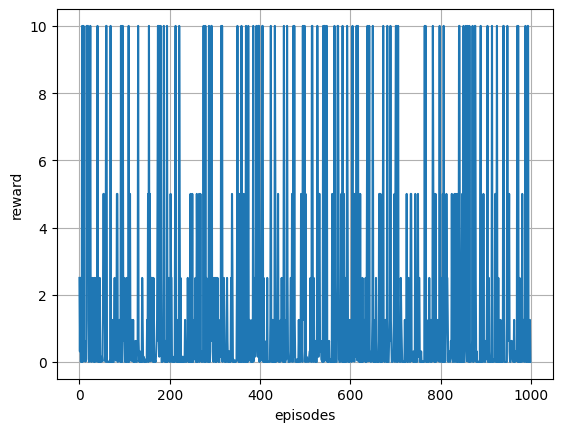

In [33]:
plt.plot(range(len(result)), result)
plt.ylabel('reward')
plt.xlabel('episodes')
plt.grid(True)
plt.show()

env.close()